In [80]:
import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')

import tensorflow as tf
from tensorflow import keras
from keras import preprocessing
from keras.layers import Dense
from keras.models import Sequential, load_model
from keras.models import Model
from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, GlobalAveragePooling1D
import transformers as ppb # pytorch-pretrained-bert
# from transformers import_version_; print(_version_)
from transformers import BertTokenizer
from transformers import BertModel, BertForMaskedLM
import torch
import pipeline as pp
import models as ml
import numpy as np
import pandas as pd
import model_tests as mt
import importlib

# import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
# conffusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
#f score
from sklearn.metrics import f1_score

# Generate dataset

Generate dataset and apply binary labels to the data.

In [51]:
importlib.reload(pp)


data = pp.apply_pipeline(
    '../datasets/sample/dataset.csv',
    [(pp.Binary_labels(), 'type', 'typeContent') ],
    # classes=[True, False],
    total_rows=5000,
    new_file='../datasets/sample/dataset_bin_raw.csv',
    progress_bar=True,
)

# write panda frame data to ../datasets/big/dataset_bin.csv"

raw_sample_file = '../datasets/sample/dataset_bin_raw.csv'


100%|██████████| 5000/5000 [00:00<00:00, 1177579.88it/s]


processed 20000 rows
finish time: 0.402724027633667


## Clean data

In [1]:
importlib.reload(pp)

def Clean_data(file, new_file, content="content"):
    stopwords_lst = stopwords.words('english')
    pp.apply_pipeline(file, [
            # Clean content
            (pp.Clean_data(), content, "content_cleaned"),
            (pp.Tokenizer(), "content_cleaned", "content_tokenized"),
            (pp.Remove_stopwords(stopwords_lst), "content_tokenized"),
            (pp.Stem(), "content_tokenized"),
            (pp.Combine_Content(), "content_tokenized", "content_combined"), # join all the words in the list to a string
            # Clean authors
            # (pp.Clean_author(), "authors"),
            # # Clean title
            # (pp.Clean_data(), 'title'),
            # (pp.Tokenizer(), "title"),
            # (pp.Remove_stopwords(stopwords_lst), "title"),
            # (pp.Stem(), "title"),
            # (pp.Combine_Content(), "title"),
            # # Clean domain
            # (pp.Clean_domain(), 'domain'),
            # Combine columns (used as features)
            # (pp.Join_str_columns(["content_combined", "authors"]), None, "content_authors"),
            # (pp.Join_str_columns(["content_combined", "title"]), None, "content_title"),
            # (pp.Join_str_columns(["content_combined", "domain"]), None, "content_domain"),
            # (pp.Join_str_columns(["content_combined", "domain", "authors", "title"]), None, "content_domain_authors_title")
        ],
        new_file=new_file,
        progress_bar=True,
    )



Clean_data(raw_sample_file, "../datasets/big/dataset_unbalanced_cleaned.csv")
cleaned_content_list = "content_tokenized"
cleaned_content_string = "content_combined"
# cleaned_data = pd.read_csv("../datasets/big/dataset_unbalanced_cleaned.csv")



NameError: name 'importlib' is not defined

# Split the data to training set

In [27]:
importlib.reload(pp)
fromfile = "../datasets/big/dataset.csv"

pp.get_dataframe_with_distribution(fromfile, 100000, [0.8,0.1,0.1], [False, False, False], 
                                   out_file="../datasets/sample/dataset_unbalanced.csv", get_frame=False)

cleaned_data = pd.read_csv("../datasets/sample/dataset_unbalanced.csv")

100%|██████████| 20000/20000 [00:00<00:00, 588121.21it/s]


entries read: 100000


## Cluster the data (optional)

To find underlying clusters in the data, we use the KMeans algorithm.


In [89]:
# Vectorize the corpus using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(cleaned_data['content_combined'].values.astype('U'))

### Plot the elbow curve to determine the optimal number of clusters.

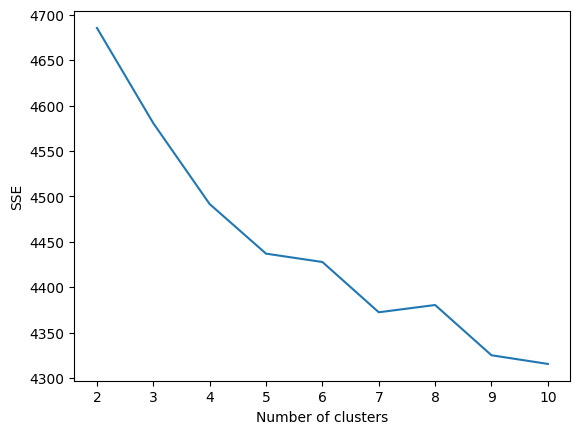

In [90]:
# Calculate SSE for different values of k
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

models = []

sse = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, max_iter=1000, n_init=10).fit(tfidf)
    models.append(kmeans)
    sse[k] = kmeans.inertia_ 

# Plot SSE against k
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

### Define the number of clusters

In [91]:
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=10)
kmeans.fit(tfidf)

KMeans(max_iter=100, n_clusters=5, n_init=10)

### Plot the clusters using a a scatterplot in 2d with PCA.

In [92]:
label_to_color = {0: 'red', 1: 'blue', 2: 'green', 3: 'violet', 4: "yellow", 5: "orange"}

In [ ]:
from sklearn.decomposition import PCA

# Reduce the dimensions of the data using PCA
pca = PCA(n_components=2)
tfidf_2d = pca.fit_transform(tfidf.toarray())

colors = [label_to_color[label] for label in kmeans.labels_]

# Visualize the clusters
plt.scatter(tfidf_2d[:, 0], tfidf_2d[:, 1], 
            c=colors, 
            cmap='rainbow',
            )
plt.show()

In [93]:
# Print the top terms in each cluster
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1] # sort the centroids by their distance to the origin
terms = tfidf_vectorizer.get_feature_names_out()
for i in range(num_clusters):
    print(f"Cluster {label_to_color[i]} terms: ", end='')
    for j in order_centroids[i, :10]:
        print(f"{terms[j]}, ", end='')
    print()

Top terms per cluster:
Cluster red terms: num, date, url, said, new, time, mr, peopl, state, year, 
Cluster blue terms: updat, bookmark, sputnik, pleas, dear, excit, radio, whitelist, adblock, voic, 
Cluster green terms: tor, tail, anonymis, usb, browser, dvd, submiss, stick, comput, internet, 
Cluster violet terms: rec, num, trump, republican, moor, date, diari, roy, senat, thread, 
Cluster yellow terms: iran, iranian, nuclear, suprem, islam, minist, leader, tehran, ali, republ, 


### Add the cluster labels to the data as a feature

In [150]:
cleaned_data['cluster'] = kmeans.labels_
# add the cluster label to the content

# concat the cluster label to the content

# create a new column 'cluster_color' that maps cluster labels to color codes
cleaned_data['cluster_color'] = cleaned_data['cluster'].map(label_to_color)

# create a new column 'cluster_string' that concatenates the color code and cluster label string
cleaned_data['cluster_string'] = cleaned_data['cluster_color'] + 'Cluster'

cleaned_data['content_with_cluster'] = cleaned_data['content_combined'] + ' ' + cleaned_data['cluster_string'].astype(str)

In [151]:
cleaned_data['content_with_cluster'][0]

'editor drop colleg editori march <num> written favor elector colleg reform sinc <date> would prefer popular elect presid gimmick endors individu state bind elector vote nation popularvot winner seem problemat one basic reason stop state legislatur strong partisan loyalti abandon agreement urgent calcul parti advantag come fore ? one legislatur anoth undo end difficult might presidentialelect reform depend take amend process serious that exampl editori cite conclus demonstr although individu state set legisl preced grant suffrag africanamerican women also popular elect senat end right entrench constitut amend left unstabl legisl gimmickri jack rakov stanford calif march <date> writer professor histori american studi polit scienc stanford univers draw draw thoma fuch redCluster'

### Add top termas as features

In [129]:
# Print the top terms in each cluster
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1] # sort the centroids by their distance to the origin
terms = tfidf_vectorizer.get_feature_names_out()
for i in range(num_clusters):
    print(f"Cluster {label_to_color[i]} terms: ", end='')
    top_terms = ', '.join([terms[j] for j in order_centroids[i, :10]]).replace(',', '')
    print(top_terms)
    cleaned_data.loc[cleaned_data['cluster'] == i, 'content_with_top_terms'] = cleaned_data.loc[cleaned_data['cluster'] == i, 'content_combined'] + ' ' + top_terms

# write data to csv
# cleaned_data.to_csv("../datasets/sample/dataset_unbalanced_with_clusters.csv", index=False)

Top terms per cluster:
Cluster red terms: num date url said new time mr peopl state year
Cluster blue terms: updat bookmark sputnik pleas dear excit radio whitelist adblock voic
Cluster green terms: tor tail anonymis usb browser dvd submiss stick comput internet
Cluster violet terms: rec num trump republican moor date diari roy senat thread
Cluster yellow terms: iran iranian nuclear suprem islam minist leader tehran ali republ


In [115]:
# Clean_data("../datasets/sample/dataset_unbalanced_with_clusters.csv", "../datasets/big/dataset_unbalanced_cleaned.csv")
# cleaned_content_list = "content_tokenized"
# cleaned_content_string = "content_combined"

100%|██████████| 5000/5000 [00:00<00:00, 160401.40it/s]


processed 20000 rows
finish time: 33.5052752494812


In [130]:
# cleaned_data.head(1)
cleaned_data.iloc[0]['content_with_top_terms']

'editor drop colleg editori march <num> written favor elector colleg reform sinc <date> would prefer popular elect presid gimmick endors individu state bind elector vote nation popularvot winner seem problemat one basic reason stop state legislatur strong partisan loyalti abandon agreement urgent calcul parti advantag come fore ? one legislatur anoth undo end difficult might presidentialelect reform depend take amend process serious that exampl editori cite conclus demonstr although individu state set legisl preced grant suffrag africanamerican women also popular elect senat end right entrench constitut amend left unstabl legisl gimmickri jack rakov stanford calif march <date> writer professor histori american studi polit scienc stanford univers draw draw thoma fuch num date url said new time mr peopl state year'

### Get balanced or unbalanced dataset

In [34]:
# importlib.reload(pp)
# from_file = '../datasets/sample/dataset_bin_raw.csv'
# # from_file = '../datasets/sample/news_sample_cleaned_num_100k.csv'
# TOTALSIZE = 5000

# pp.get_dataframe_with_distribution(
#         from_file, 
#         total_size = TOTALSIZE, 
#         splits=[0.8,0.1,0.1], 
#         balanced=[False, False, False], 
#         out_file="../datasets/big/dataset_unbalanced.csv", 
#         get_frame=False
#     )



100%|██████████| 5000/5000 [00:00<00:00, 961026.49it/s]


entries to read: 0
entries read: 20000


In [78]:
pd.read_csv("../datasets/big/dataset_unbalanced_cleaned.csv").iloc[0]["content_tokenized"]

"['editor', 'drop', 'colleg', 'editori', 'march', '<num>', 'written', 'favor', 'elector', 'colleg', 'reform', 'sinc', '<date>', 'would', 'prefer', 'popular', 'elect', 'presid', 'gimmick', 'endors', 'individu', 'state', 'bind', 'elector', 'vote', 'nation', 'popularvot', 'winner', 'seem', 'problemat', 'one', 'basic', 'reason', 'stop', 'state', 'legislatur', 'strong', 'partisan', 'loyalti', 'abandon', 'agreement', 'urgent', 'calcul', 'parti', 'advantag', 'come', 'fore', '?', 'one', 'legislatur', 'anoth', 'undo', 'end', 'difficult', 'might', 'presidentialelect', 'reform', 'depend', 'take', 'amend', 'process', 'serious', 'that', 'exampl', 'editori', 'cite', 'conclus', 'demonstr', 'although', 'individu', 'state', 'set', 'legisl', 'preced', 'grant', 'suffrag', 'africanamerican', 'women', 'also', 'popular', 'elect', 'senat', 'end', 'right', 'entrench', 'constitut', 'amend', 'left', 'unstabl', 'legisl', 'gimmickri', 'jack', 'rakov', 'stanford', 'calif', 'march', '<date>', 'writer', 'professor',

# Define the model

### Define function to split the data

# Model B - tensorflow (word embedding, neural network)

### Tokenize the data and make sequences

In [64]:
importlib.reload(mt)
data = pd.read_csv("../datasets/sample/dataset_unbalanced_10K.csv", usecols=["content_combined", "type_binary","set"])
X_train, X_val, X_test, y_train, y_val, y_test = mt.split_data(data, "content_combined", "type_binary")
del data

### ...

In [152]:
df = cleaned_data
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")

# col = "content_with_top_terms"
col = "content_with_cluster"
# col = "content_combined"


# all cleaned
tokenizer.fit_on_texts(df[df["set"] == 0][col])
sequences = tokenizer.texts_to_sequences(df[col])
df["padded_sequences_all"] = pad_sequences(sequences, maxlen=1000, truncating="post").tolist()


### Create CSR (Compressed Sparse Row) matrix to use in models

The function first splits the input data into three sets based on the values in the set column: a training set (where set=0), a validation set (where set=1), and a test set (where set=2).

Next, the function applies the stack_func stacking function to the feature column of each set of data to convert it into a CSR (Compressed Sparse Row) matrix. A CSR matrix is a sparse matrix format that stores data in a compressed way, which can be more memory-efficient than other formats for sparse data.

The function also converts the y column of each set of data into an integer type.

### ...

In [154]:
def split_csr_data(data: pd.DataFrame, feature: str, y, stack_func, set="set", get_val=True):
    train = data[data[set] == 0]
    val = data[data[set] == 1]
    test = data[data[set] == 2]

    X_train, y_train = stack_func(train[feature]), train[y].astype(int)
    X_val, y_val = stack_func(val[feature]), val[y].astype(int)
    X_test, y_test = stack_func(test[feature]), test[y].astype(int)
    if not get_val:
        return X_train, X_test, y_train, y_test
    return X_train, X_val, X_test, y_train, y_val, y_test

In [155]:
X_train_stacked, X_val_stacked, X_test_stacked, y_train_stacked, y_val_stacked, y_test_stacked = split_csr_data(
    df, 
    "padded_sequences_all", "typeContent", 
    lambda x: np.array(x.tolist()), 
    get_val=True
    )

### Model

In [4]:
# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 1))

# Fit the vectorizer on the documents
vectorizer.fit(X_train)
print("fitting finished")

# Transform the documents into TF-IDF vectors
X_train_vec = vectorizer.transform(X_train).toarray()
X_val_vec = vectorizer.transform(X_val).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()
print("transforming finished")

# Define the input and output shapes
input_shape = X_train_vec.shape[1]
output_shape = 2

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(input_shape,)),
    tf.keras.layers.Dense(output_shape, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train_vec, y_train, epochs=10, validation_data=(X_val_vec, y_val))
metrics = model.evaluate(X_val_vec, y_val)
print(f"Loss: {metrics[0]}, Accuracy: {metrics[1]}")

fitting finished
transforming finished
Epoch 1/10


InvalidArgumentError: Graph execution error:

TypeError: 'SparseTensor' object is not subscriptable
Traceback (most recent call last):

  File "c:\Users\madsv\miniconda3\envs\penguin\lib\site-packages\tensorflow\python\ops\script_ops.py", line 269, in __call__
    return func(device, token, args)

  File "c:\Users\madsv\miniconda3\envs\penguin\lib\site-packages\tensorflow\python\ops\script_ops.py", line 147, in __call__
    outputs = self._call(device, args)

  File "c:\Users\madsv\miniconda3\envs\penguin\lib\site-packages\tensorflow\python\ops\script_ops.py", line 154, in _call
    ret = self._func(*args)

  File "c:\Users\madsv\miniconda3\envs\penguin\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "c:\Users\madsv\miniconda3\envs\penguin\lib\site-packages\keras\engine\data_adapter.py", line 511, in py_method
    return [slice_array(inp) for inp in flat_inputs]

  File "c:\Users\madsv\miniconda3\envs\penguin\lib\site-packages\keras\engine\data_adapter.py", line 511, in <listcomp>
    return [slice_array(inp) for inp in flat_inputs]

  File "c:\Users\madsv\miniconda3\envs\penguin\lib\site-packages\keras\engine\data_adapter.py", line 507, in slice_array
    return training_utils.slice_arrays(

  File "c:\Users\madsv\miniconda3\envs\penguin\lib\site-packages\keras\engine\training_utils.py", line 47, in slice_arrays
    entries = [[x[i : i + 1] for i in indices] for x in arrays]

  File "c:\Users\madsv\miniconda3\envs\penguin\lib\site-packages\keras\engine\training_utils.py", line 47, in <listcomp>
    entries = [[x[i : i + 1] for i in indices] for x in arrays]

  File "c:\Users\madsv\miniconda3\envs\penguin\lib\site-packages\keras\engine\training_utils.py", line 47, in <listcomp>
    entries = [[x[i : i + 1] for i in indices] for x in arrays]

TypeError: 'SparseTensor' object is not subscriptable


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_749]

In [113]:
importlib.reload(pp)
pp.apply_pipeline("../datasets/big/combined_cleaned.csv", [(pp.Binary_labels_LIAR(), 'label', 'type_binary')], new_file="../datasets/big/combined_cleaned_bin.csv")

processed 20000 rows
finish time: 0.304168701171875


In [114]:
liar_data = pd.read_csv("../datasets/big/combined_cleaned_bin.csv")
X_liar =  liar_data["statement_combined"].values
y_liar = liar_data["type_binary"].astype(int)

In [96]:
y_liar

0        0
1        1
2        1
3        0
4        1
        ..
12786    1
12787    0
12788    0
12789    0
12790    0
Name: type_binary, Length: 12791, dtype: int32

In [115]:
print(len(y_liar[y_liar == 1])) # FAKE = 5657 = FN
print(len(y_liar[y_liar == 0]) ) # REAL = 7134 = TN




5657
7134


In [71]:
importlib.reload(mt)
num_words = 10000
max_len = 60
X_train_pad, X_val_pad, X_test_pad, X_liar_pad = mt.create_padded_sequences(X_train, X_val, X_test, X_liar, numwords=num_words, maxlen=max_len)

In [73]:
# Define the model architecture
num_words = 10000
max_len = 60

models = [
    (tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=num_words, output_dim=16, input_length=max_len),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ]), "Model-A"),

    (tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=num_words, output_dim=16, input_length=max_len), # 10000 words, 64 dimensions
        tf.keras.layers.LSTM(units=16, dropout=0.2, recurrent_dropout=0.2),
        tf.keras.layers.Dense(units=1, activation='sigmoid')
    ]), "Model-B"),

    (tf.keras.Sequential([
            tf.keras.layers.Embedding(input_dim=num_words, output_dim=16, input_length=max_len), # 10000 words, 64 dimensions
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.LSTM(100),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation='sigmoid')
    ]), "Model-C"),

    (tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=num_words, output_dim=16, input_length=max_len),
        tf.keras.layers.Conv1D(128, 5, activation='relu'),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
]), "Model-E")

]   

# print("Creating padded sequences")
# X_train_pad, X_val_pad, X_test_pad = mt.create_padded_sequences(X_train, X_val, X_test, numwords=num_words, maxlen=max_len)
# print("Padded sequences created")

for model, name in models:
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

history = []
# for model, name in models:
for model, name in models:
    print(f"Training {name}")
    # Train the model
    history.append(model.fit(X_train_pad, y_train, epochs=10, validation_data=(X_val_pad, y_val)))

    # Evaluate the model
    metrics = model.evaluate(X_val_pad, y_val)
    print(f"Loss {metrics[0]}, Accuracy {metrics[1]}, Precision {metrics[2]}, Recall {metrics[3]}")


Training Model-A
Epoch 1/10
250/250 [==============================] - 4s 7ms/step - loss: 0.6324 - accuracy: 0.6661 - precision_7: 0.6642 - recall_7: 0.7241 - val_loss: 0.5512 - val_accuracy: 0.7090 - val_precision_7: 0.6736 - val_recall_7: 0.8669
Epoch 2/10
250/250 [==============================] - 2s 7ms/step - loss: 0.4429 - accuracy: 0.8062 - precision_7: 0.7883 - recall_7: 0.8580 - val_loss: 0.4432 - val_accuracy: 0.7800 - val_precision_7: 0.7713 - val_recall_7: 0.8270
Epoch 3/10
250/250 [==============================] - 1s 6ms/step - loss: 0.3153 - accuracy: 0.8691 - precision_7: 0.8732 - recall_7: 0.8755 - val_loss: 0.4328 - val_accuracy: 0.7930 - val_precision_7: 0.8004 - val_recall_7: 0.8080
Epoch 4/10
250/250 [==============================] - 1s 6ms/step - loss: 0.2372 - accuracy: 0.9062 - precision_7: 0.9147 - recall_7: 0.9041 - val_loss: 0.4579 - val_accuracy: 0.7940 - val_precision_7: 0.7952 - val_recall_7: 0.8194
Epoch 5/10
250/250 [==============================] - 1

In [ ]:
[[41544  6005]
 [ 5221 47230]]
{'acc': 0.88774, 'precision': 0.9004594764637471, 'recall': 0.8871982718136564, 'f1': 0.8937796869973318}

Evaluating Model-A
3125/3125 [==============================] - 4s 1ms/step
Confusion matrix for Model-A
Fake news predicted correctly: 40151


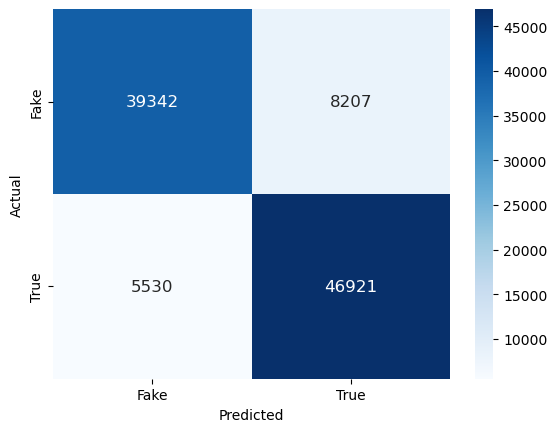

VAL: Loss 0.3069673180580139, Accuracy 0.8636800050735474, Precision 0.8512405753135681, Recall 0.8942410945892334 f1: 0.8722111689314535
TEST: Loss 0.30670011043548584, Accuracy 0.8626300096511841, Precision 0.8511282801628113, Recall 0.8945682644844055, f1: 0.8723077911490175
LIAR: Loss 1.082379698753357, Accuracy 0.5176295638084412, Precision 0.5764836668968201, Recall 0.5092514753341675 f1: 0.5407859549797993
Evaluating Model-B
3125/3125 [==============================] - 15s 5ms/step
Confusion matrix for Model-B
Fake news predicted correctly: 40151


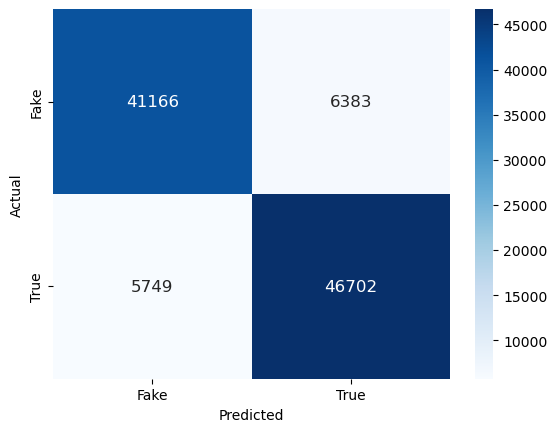

VAL: Loss 0.2691591680049896, Accuracy 0.8781700134277344, Precision 0.8768753409385681, Recall 0.8909157514572144 f1: 0.88383978929076
TEST: Loss 0.2675608694553375, Accuracy 0.8786799907684326, Precision 0.879758894443512, Recall 0.8903929591178894, f1: 0.8850439850771481
LIAR: Loss 0.8748524188995361, Accuracy 0.528340220451355, Precision 0.5817129015922546, Recall 0.5493412017822266 f1: 0.5650637993346501
Evaluating Model-D
3125/3125 [==============================] - 40s 13ms/step
Confusion matrix for Model-D
Fake news predicted correctly: 40151


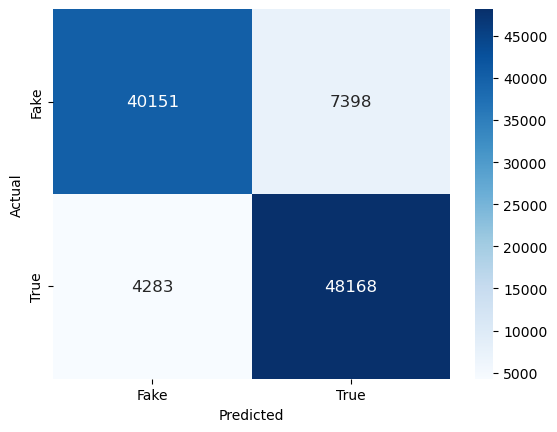

VAL: Loss 0.2500036656856537, Accuracy 0.882860004901886, Precision 0.8643479347229004, Recall 0.9190757870674133 f1: 0.8908721451883264
TEST: Loss 0.25045743584632874, Accuracy 0.8831899762153625, Precision 0.8668610453605652, Recall 0.9183428287506104, f1: 0.8918596201528926
LIAR: Loss 0.8456322550773621, Accuracy 0.5215385556221008, Precision 0.5805785059928894, Recall 0.5120549201965332 f1: 0.5441680135867866


In [52]:
importlib.reload(mt)

for model, name in models:
    # Evaluate the model
    print(f"Evaluating {name}")
    y_pred = model.predict(X_test_pad).round()
    #print(mt.get_metrics(y_test, y_pred))
    print(f"Confusion matrix for {name}")
    cm = confusion_matrix(y_test, y_pred)
    # print 0,0
    print("Fake news predicted correctly:", k)
    sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=["Fake","True"], yticklabels=["Fake","True"], fmt="d", annot_kws={"size": 12})
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    metrics = model.evaluate(X_val_pad, y_val, verbose=0)
    print(f"VAL: Loss {metrics[0]}, Accuracy {metrics[1]}, Precision {metrics[2]}, Recall {metrics[3]} f1: {(2 * (metrics[2] * metrics[3]) / (metrics[2] + metrics[3]))}")
    metrics = model.evaluate(X_test_pad, y_test, verbose=0)
    print(f"TEST: Loss {metrics[0]}, Accuracy {metrics[1]}, Precision {metrics[2]}, Recall {metrics[3]}, f1: {(2 * (metrics[2] * metrics[3]) / (metrics[2] + metrics[3]))}")
    metrics = model.evaluate(X_liar, y_liar, verbose=0)
    print(f"LIAR: Loss {metrics[0]}, Accuracy {metrics[1]}, Precision {metrics[2]}, Recall {metrics[3]} f1: {(2 * (metrics[2] * metrics[3]) / (metrics[2] + metrics[3]))}")


dict_keys(['loss', 'accuracy', 'precision_10', 'recall_10', 'val_loss', 'val_accuracy', 'val_precision_10', 'val_recall_10'])


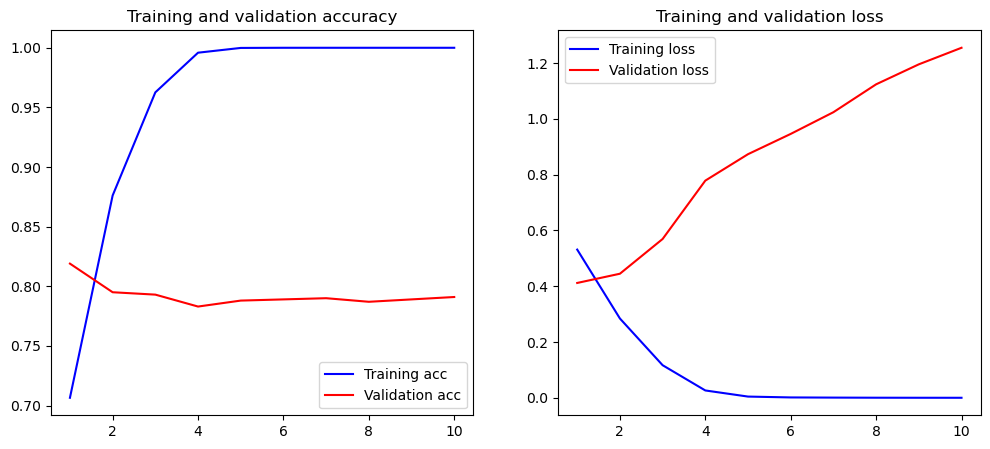

In [74]:
def plot_history(history):

    print(history.history.keys())
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)


In [62]:
unbalanced = "../datasets/sample/dataset_unbalanced_1M.csv"

unbalanced_data = pd.read_csv(unbalanced, usecols=["content_title"], nrows=100000)

In [63]:

def func(x):
    if type(x) != str:
        print(x)
    return x


_ = unbalanced_data["content_title"].apply(func)


nan


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

# Download and load pre-trained GloVe embeddings
embeddings_index = {}
with open('../datasets/glove/glove.6B.100d.txt', encoding='utf8') as f: # http://nlp.stanford.edu/data/glove.6B.zip
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Tokenize input text
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_sequence = tokenizer.texts_to_sequences(X_train)
X_val_sequence = tokenizer.texts_to_sequences(X_val)
X_test_sequence = tokenizer.texts_to_sequences(X_test)

word_index = tokenizer.word_index 
print(word_index)

# Pad input sequences
max_len = 100
X_train_pad = pad_sequences(X_train_sequence, maxlen=max_len)
X_val_pad = pad_sequences(X_val_sequence, maxlen=max_len)
X_test_pad = pad_sequences(X_test_sequence, maxlen=max_len)

# Create embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Define model
model = Sequential([
    Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False),
    Flatten(),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_data=(X_val_pad, y_val))
metrics = model.evaluate(X_val_pad, y_val)


In [4]:
metrics

[0.2500036656856537, 0.882860004901886, 0.8643479347229004, 0.9190757870674133]

In [ ]:
# LSTM + glove model

# LSTM + glove model

In [85]:
# import flatten 
from keras.layers import Flatten

# Load pre-trained GloVe embeddings
embeddings_index = {}
with open('../datasets/glove/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Define the model architecture
model = Sequential()

model.add(Embedding(input_dim=10000, output_dim=100, input_length=1000))
model.add(LSTM(units=64))
model.add(Dropout(0.3))
model.add(Dense(units=1, activation='sigmoid'))

# model.add(LSTM(units=64))
# model.add(Dropout(0.3))
# # model.add(Dense(64, activation='relu'))
# model.add(Dense(units=1, activation='relu'))

# model.add(Dropout(0.3))
# # model.add(Flatten())
# model.add(Dense(1, activation='sigmoid'))

# Set the GloVe embedding matrix for the Embedding layer
embedding_matrix = np.zeros((10000, 100))
for word, i in tokenizer.word_index.items():
    if i < 10000:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

history = model.fit(X_train_stacked, y_train_stacked, validation_data=(X_test_stacked, y_test), epochs=10)


NameError: name 'tokenizer' is not defined

# Most successful model from list

In [84]:

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=16, input_length=1000), # 10000 words, 64 dimensions
    tf.keras.layers.LSTM(units=16, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
model.fit(X_train_stacked, y_train_stacked, epochs=10, validation_data=(X_val_stacked, y_val_stacked))

# Evaluate the model
# model.evaluate(X_test, y_test)

model.evaluate(X_test_stacked, y_test_stacked)


Epoch 1/10
125/125 [==============================] - 41s 318ms/step - loss: 0.6214 - accuracy: 0.6715 - val_loss: 0.5209 - val_accuracy: 0.7740
Epoch 2/10
125/125 [==============================] - 39s 309ms/step - loss: 0.4058 - accuracy: 0.8257 - val_loss: 0.4422 - val_accuracy: 0.7960
Epoch 3/10
125/125 [==============================] - 39s 308ms/step - loss: 0.2533 - accuracy: 0.9118 - val_loss: 0.5376 - val_accuracy: 0.7900
Epoch 4/10
125/125 [==============================] - 39s 309ms/step - loss: 0.1646 - accuracy: 0.9433 - val_loss: 0.5695 - val_accuracy: 0.7920
Epoch 5/10
125/125 [==============================] - 39s 310ms/step - loss: 0.1021 - accuracy: 0.9695 - val_loss: 0.6770 - val_accuracy: 0.7760
Epoch 6/10
125/125 [==============================] - 39s 313ms/step - loss: 0.0771 - accuracy: 0.9775 - val_loss: 0.8155 - val_accuracy: 0.7800
Epoch 7/10
125/125 [==============================] - 39s 316ms/step - loss: 0.0543 - accuracy: 0.9845 - val_loss: 0.6902 - val_ac

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [135]:
model.evaluate(X_test_stacked, y_test_stacked)

16/16 [==============================] - 1s 61ms/step - loss: 0.8279 - accuracy: 0.7780


[0.8278565406799316, 0.777999997138977]

In [137]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 1000, 16)          160000    
                                                                 
 lstm_7 (LSTM)               (None, 16)                2112      
                                                                 
 dense_15 (Dense)            (None, 1)                 17        
                                                                 
Total params: 162,129
Trainable params: 162,129
Non-trainable params: 0
_________________________________________________________________


Our model has 162,129 parameters to train which means 162,129 partial gradients to calculate and optimize for each epoch. Clearly, the optimization problem is is going to have numerous local minima and look something like this:


In [96]:
list

['To',
 'the',
 'Editor:',
 'Re',
 "''Drop",
 'Out',
 'of',
 'the',
 "College''",
 '(editorial,',
 'March',
 '14):',
 'Having',
 'written',
 'in',
 'favor',
 'of',
 'Electoral',
 'College',
 'reform',
 'since',
 '2000,',
 'I,',
 'too,',
 'would',
 'prefer',
 'the',
 'popular',
 'election',
 'of',
 'the',
 'president.',
 'But',
 'the',
 'gimmick',
 'you',
 'endorse,',
 'of',
 'having',
 'individual',
 'states',
 'bind',
 'their',
 'electors',
 'to',
 'vote',
 'for',
 'the',
 'national',
 'popular-vote',
 'winner,',
 'seems',
 'problematic',
 'for',
 'one',
 'basic',
 'reason.',
 'What',
 'is',
 'to',
 'stop',
 'state',
 'legislatures',
 'with',
 'strong',
 'partisan',
 'loyalties',
 'of',
 'their',
 'own',
 'from',
 'abandoning',
 'such',
 'an',
 'agreement',
 'when',
 'urgent',
 'calculations',
 'of',
 'party',
 'advantage',
 'come',
 'to',
 'the',
 'fore?',
 'What',
 'one',
 'legislature',
 'can',
 'do,',
 'another',
 'can',
 'undo.',
 'In',
 'the',
 'end,',
 'difficult',
 'as',
 'it'

# Model C - tensorflow (word embedding, neural network)

### Model D - tensorflow (word embedding, neural network)

# ...

In [171]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten

# Create a corpus of text data
corpus = ["I like apples", "I love oranges", "She hates pears", "He dislikes bananas"]

# Create a dictionary of words and their indices
word_dict = {}
for sentence in corpus:
    for word in sentence.split():
        if word not in word_dict:
            word_dict[word] = len(word_dict)

print(word_dict)

# Convert the corpus into a matrix of word indices
corpus_matrix = np.zeros((len(corpus), len(word_dict)))
for i, sentence in enumerate(corpus):
    for word in sentence.split():
        corpus_matrix[i, word_dict[word]] = 1

print(corpus_matrix)

# Create a neural network model with an embedding layer
model = Sequential()
model.add(Embedding(len(word_dict), 10, input_length=len(word_dict)))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(corpus_matrix, np.array([1, 1, 0, 0]), epochs=100, verbose=0)

# Get the learned word embeddings
embeddings = model.get_weights()[0]

# Print the learned embeddings for each word
for word, index in word_dict.items():
    print(word, embeddings[index])


{'I': 0, 'like': 1, 'apples': 2, 'love': 3, 'oranges': 4, 'She': 5, 'hates': 6, 'pears': 7, 'He': 8, 'dislikes': 9, 'bananas': 10}
[[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]
I [ 0.01084691  0.05905872  0.10306235 -0.14502099 -0.12997098 -0.13813913
 -0.06073071 -0.09133526 -0.07036315 -0.15299843]
like [ 0.01004097 -0.05609348 -0.150103    0.12210258  0.15346912  0.10471579
  0.13184628  0.1534519   0.14802444  0.07126988]
apples [-0.03393108  0.0453754  -0.04307861 -0.0285189   0.0429468   0.04903771
  0.0077204   0.0107735  -0.0385612   0.03291475]
love [-0.01634374  0.02703054 -0.03767378 -0.01324936  0.00145559  0.00185931
 -0.00423161  0.03586557 -0.02062558  0.00826403]
oranges [-0.00947602  0.01159532  0.03997704  0.04474339  0.02783946 -0.04896856
 -0.00519222  0.00521594  0.01004098  0.03216121]
She [ 0.01494067 -0.02341055  0.00772437  0.00648074  0.00123427  0.04053677
 -0.0

In [ ]:
# Load the dataset
df = pd.read_csv('fake_news_dataset.csv')

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Convert the text data to sequences of word indices
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the sequences to a fixed length
max_len = 1000
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Create the word embedding matrix
word_index = tokenizer.word_index
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index)+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = word_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Create the neural network model
model = Sequential()
model.add(Embedding(len(word_index)+1, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=False))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train_pad, y_train, batch_size=32, epochs=10, validation_data=(X_test_pad, y_test))

# Evaluate the model on the test set
score = model.evaluate(X_test_pad, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
